# Proyek Klasifikasi Gambar: [Multi Cancer Dataset (Brain Tumor)]
- **Nama:** Fadhil Ramadhan Masthofani
- **Email:** masthofani@gmail.com
- **ID Dicoding:** Fadhil Ramadhan Masthofani

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Split data train dan validation
local_zip = '/content/drive/MyDrive/Colab Notebooks/ML Intermediate/Klasifikasi Gambar/brain cancer.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

base_dir = '/content'
train_dir = os.path.join(base_dir, 'brain_glioma')
test_dir = os.path.join(base_dir, 'brain_menin')


{'brain_tumor': ['brain_tumor_1170.jpg', 'brain_tumor_4916.jpg', 'brain_tumor_4180.jpg', 'brain_tumor_4789.jpg', 'brain_tumor_1128.jpg', 'brain_tumor_3109.jpg', 'brain_tumor_1857.jpg', 'brain_tumor_1793.jpg', 'brain_tumor_0571.jpg', 'brain_tumor_4820.jpg', 'brain_tumor_0562.jpg', 'brain_tumor_1520.jpg', 'brain_tumor_3397.jpg', 'brain_tumor_2034.jpg', 'brain_tumor_2717.jpg', 'brain_tumor_0458.jpg', 'brain_tumor_1612.jpg', 'brain_tumor_3202.jpg', 'brain_tumor_1832.jpg', 'brain_tumor_2262.jpg', 'brain_tumor_0756.jpg', 'brain_tumor_2984.jpg', 'brain_tumor_1583.jpg', 'brain_tumor_3404.jpg', 'brain_tumor_0948.jpg', 'brain_tumor_4111.jpg', 'brain_tumor_3458.jpg', 'brain_tumor_0421.jpg', 'brain_tumor_2002.jpg', 'brain_tumor_4550.jpg', 'brain_tumor_0236.jpg', 'brain_tumor_0469.jpg', 'brain_tumor_4217.jpg', 'brain_tumor_4383.jpg', 'brain_tumor_3668.jpg', 'brain_tumor_3187.jpg', 'brain_tumor_4942.jpg', 'brain_tumor_3942.jpg', 'brain_tumor_4738.jpg', 'brain_tumor_2258.jpg', 'brain_tumor_3635.jpg',

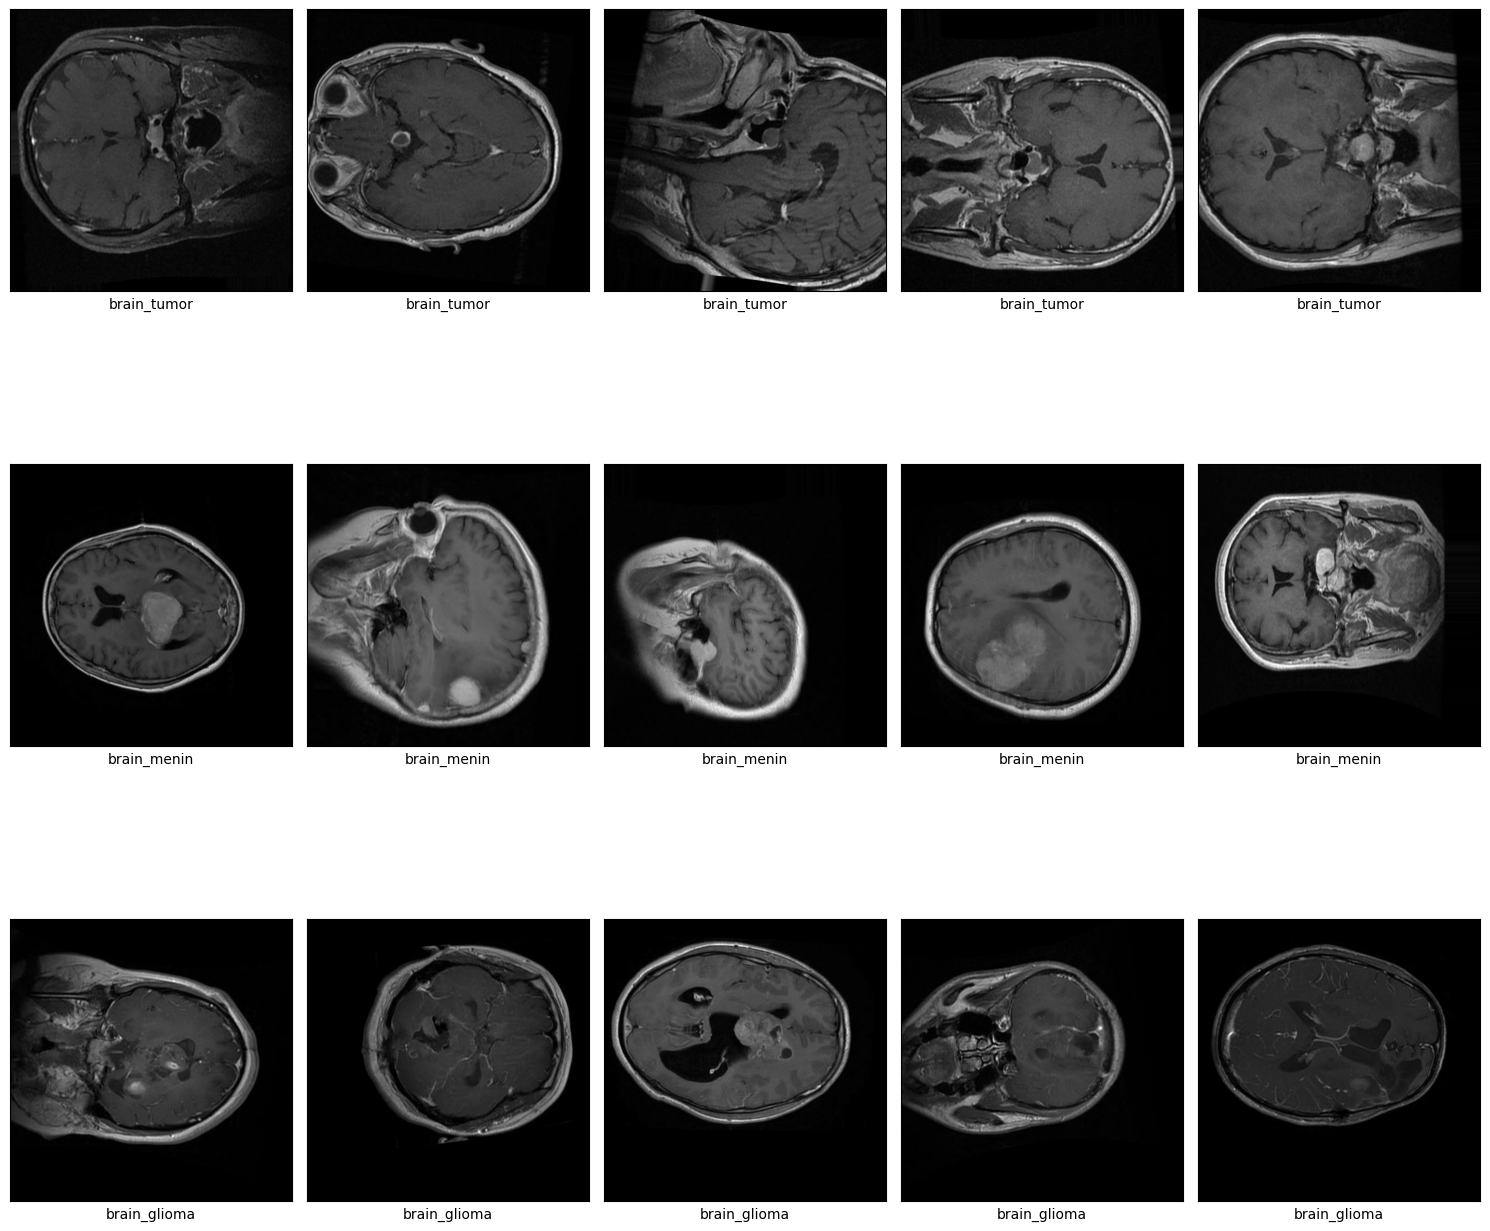

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
brain_image = {}

# Tentukan path sumber train
path = "/content"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    brain_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "/content/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(brain_image.keys()), 5, figsize=(15, 15))

print(brain_image) # Check the brain_image dictionary

for i, class_name in enumerate(os.listdir(path_sub)):
    if brain_image[class_name]:  # Check if the list is not empty
        images = np.random.choice(brain_image[class_name], 5, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(path_sub, class_name, image_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
    else:
        print(f"Warning: No images found in {class_name}")
        for j in range(5):
          axs[i,j].axis('off') #remove axis from empty plots.

fig.tight_layout()
plt.show()

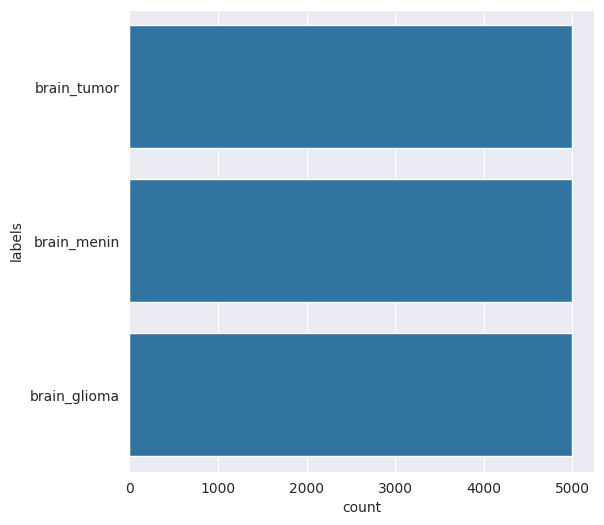

In [ ]:
# Define source path
brain_path = "/content/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(brain_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
def hitung_file_gambar(direktori):
    """Menghitung jumlah total file gambar di dalam direktori dan subdirektorinya."""

    jumlah_file = 0
    ekstensi_gambar = ['.jpg', '.jpeg', '.png']  # Daftar ekstensi file gambar yang umum

    for root, dirs, files in os.walk(direktori):
        for file in files:
            if any(file.lower().endswith(ext) for ext in ekstensi_gambar):
                jumlah_file += 1

    return jumlah_file

# Ganti 'path/ke/folder/dataset' dengan path ke folder dataset Anda
direktori_dataset = brain_path

total_file_gambar = hitung_file_gambar(direktori_dataset)
print(f"Total file gambar di dalam folder dataset: {total_file_gambar}")

Total file gambar di dalam folder dataset: 15000


## Modelling

#### Split Dataset

In [ ]:
# Path folder dataset gambar
mypath = '/content/dataset/'

# Fungsi untuk menggabungkan folder augmentasi
def merge_augmented_folders(mypath, augmented_suffix='_augmented'):
    for folder_name in os.listdir(mypath):
        if folder_name.endswith(augmented_suffix):
            original_folder_name = folder_name.replace(augmented_suffix, '')
            original_folder_path = os.path.join(mypath, original_folder_name)
            augmented_folder_path = os.path.join(mypath, folder_name)

            if os.path.exists(original_folder_path) and os.path.isdir(original_folder_path):
                for file_name in os.listdir(augmented_folder_path):
                    source_file = os.path.join(augmented_folder_path, file_name)
                    destination_file = os.path.join(original_folder_path, file_name)
                    shutil.move(source_file, destination_file)  # Menggunakan move untuk memindahkan file

                # Setelah semua file dipindahkan, hapus folder augmentasi yang kosong
                shutil.rmtree(augmented_folder_path)

# Gabungkan folder augmentasi
merge_augmented_folders(mypath)

In [ ]:
# Perbarui DataFrame df
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Melihat jumlah data gambar pada masing-masing label setelah penggabungan
print(df.groupby(['labels']).size())
print(df['labels'].unique()) #melihat unique labels.

labels
brain_glioma    5000
brain_menin     5000
brain_tumor     5000
dtype: int64
['brain_tumor' 'brain_menin' 'brain_glioma']


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 12000
test size 3000


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels      
test   brain_glioma     993
       brain_menin      970
       brain_tumor     1037
train  brain_glioma    4007
       brain_menin     4030
       brain_tumor     3963
dtype: int64 


                                                   path        labels    set
4003  /content/dataset/brain_menin/brain_menin_1939.jpg   brain_menin  train
9588  /content/dataset/brain_menin/brain_menin_1301.jpg   brain_menin  train
3632  /content/dataset/brain_menin/brain_menin_0232.jpg   brain_menin  train
3437  /content/dataset/brain_glioma/brain_glioma_380...  brain_glioma  train
9283  /content/dataset/brain_glioma/brain_glioma_343...  brain_glioma  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/content/dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_brain_glioma = os.path.join(TRAIN_DIR + '/brain_glioma')
train_brain_menin = os.path.join(TRAIN_DIR + '/brain_menin')
train_brain_tumor = os.path.join(TRAIN_DIR + '/brain_tumor')
test_brain_glioma = os.path.join(TEST_DIR + '/brain_glioma')
test_brain_menin = os.path.join(TEST_DIR + '/brain_menin')
test_brain_tumor = os.path.join(TEST_DIR + '/brain_tumor')



In [ ]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=64,
                                              target_size=(100,100),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)


validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=64,
                                                   target_size=(100,100),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=True)


test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=64,
                                                  target_size=(100,100),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 9601 images belonging to 3 classes.
Found 2399 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    Dropout(0.7),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,291,459 (4.93 MB)

 Trainable params: 1,291,459 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_generator,
                  epochs=60,
                  validation_data=validation_generator,
                  shuffle=False,
                  callbacks=[early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.4644 - loss: 0.9983 - val_accuracy: 0.6599 - val_loss: 0.7242
Epoch 2/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6649 - loss: 0.7299 - val_accuracy: 0.6853 - val_loss: 0.7012
Epoch 3/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.7188 - loss: 0.6498 - val_accuracy: 0.6499 - val_loss: 0.7943
Epoch 4/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7310 - loss: 0.6364 - val_accuracy: 0.7837 - val_loss: 0.5389
Epoch 5/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7960 - loss: 0.5132 - val_accuracy: 0.7774 - val_loss: 0.5389
Epoch 6/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7714 - loss: 0.5379 - val_accuracy: 0.7457 - val_loss: 0.6290
Epoch 7/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8040 - loss: 0.4949 - val_accuracy: 0.7140 - val_loss: 0.6569
Epoch 8/60
151/151 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.7974 - loss: 0.4933 - val_accu

## Evaluasi dan Visualisasi

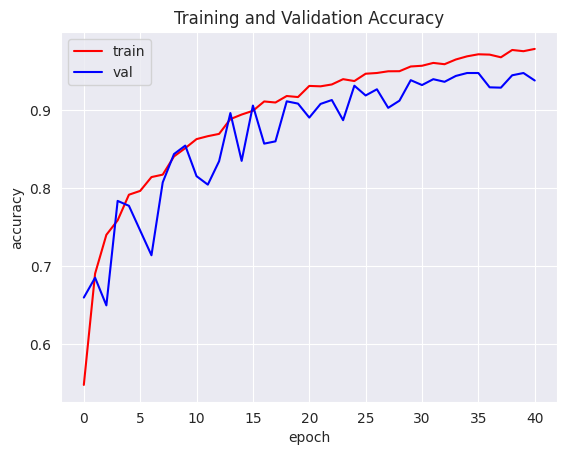

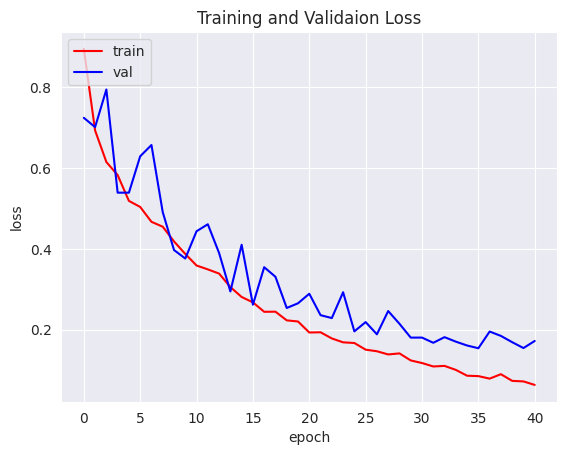

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

      Glioma     0.9646    0.9617    0.9632       993
       Menin     0.9363    0.9402    0.9383       970
       Tumor     0.9585    0.9576    0.9580      1037

    accuracy                         0.9533      3000
   macro avg     0.9532    0.9532    0.9532      3000
weighted avg     0.9534    0.9533    0.9533      3000



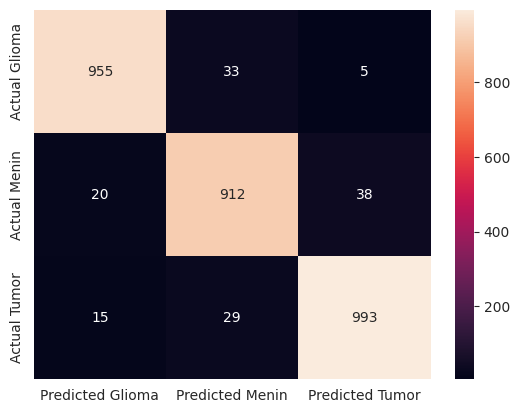

In [ ]:
# Classification Report and Confusion Matrix
test_generator.reset()

preds_1 = model.predict(test_generator, verbose=0)
preds_1_classes = preds_1.argmax(axis=-1) #Get the class with highest probability

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1_classes),
                  index=["Actual Glioma", "Actual Menin", "Actual Tumor"],
                  columns=["Predicted Glioma", "Predicted Menin", "Predicted Tumor"])
sns.heatmap(cm, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                              y_pred=preds_1_classes,
                              target_names=['Glioma', 'Menin', 'Tumor'],
                              digits=4))

## Konversi Model

In [ ]:
os.makedirs('/content', exist_ok=True)

tf.saved_model.save(model, 'saved_model')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpj99d1623'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134449918045520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918046288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918047824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918042448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918047248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918048976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918045712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449918043408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449894080976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134449894095568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13444989409537

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='output_1' --saved_model_tags=serve saved_model tfjs_model

2025-03-07 03:27:22.048329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741318042.179147   45837 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741318042.204107   45837 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-07 03:27:53.666185: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1741318074.385984   45837 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

Saving brain_glioma_0001.jpg to brain_glioma_0001 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Glioma


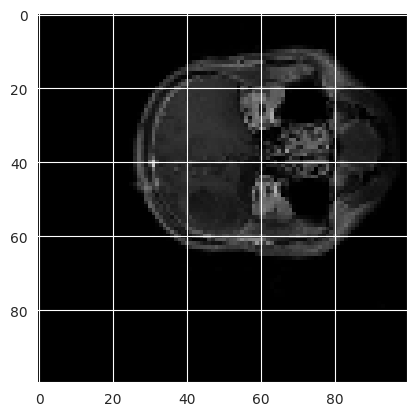

In [ ]:
# Pengujian Model dengan mengupload gambar
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(100,100))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=25)

  if classes[0,0]!=0:
    print('Glioma')
  elif classes[0,1]!=0:
    print('Menin')
  else:
    print('Tumor')

In [ ]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8a72244073bd70002024b407566760fbce6e6590ec8d0f37fe3724cdb8a6eec0
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [ ]:
!pipreqs "/content/drive/MyDrive/Colab Notebooks/ML Intermediate/Klasifikasi Gambar" --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/ML Intermediate/Klasifikasi Gambar/requirements.txt
